In [ ]:
import json

from tqdm.notebook import tqdm

import itertools
import os
import random
import pandas as pd

from solc import compile_standard
from eth_tester import PyEVMBackend, EthereumTester
import web3
web3.eth.handleRevert = True

from matplotlib import pyplot as plt
import seaborn as sns

#from solc import install_solc
#install_solc('v0.4.25')

In [58]:
def get_contract(filename, contract_name):

    with open(filename) as f:
        compiled_sol = compile_standard({
            "language": "Solidity",
            "sources": {
                filename: {
                    "content": f.read()
                }
            },
            "settings": {
                "outputSelection": {
                    "*": {
                        "*": [
                            "metadata", "evm.bytecode",
                            "evm.bytecode.sourceMap"
                        ]
                    }
                }
            }
        })
    
    # get bytecode
    bytecode = compiled_sol['contracts'][filename][contract_name]['evm']['bytecode']['object']
    # get abi
    abi = json.loads(compiled_sol['contracts'][filename][contract_name]['metadata'])['output']['abi']

    contract = w3.eth.contract(abi=abi, bytecode=bytecode)

    # Submit the transaction that deploys the contract
    tx_hash = contract.constructor().transact()
    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.getTransactionReceipt(tx_hash)

    return w3.eth.contract(
        address=tx_receipt.contractAddress,
        abi=abi
    )

In [59]:
w3 = web3.Web3(web3.Web3.EthereumTesterProvider(EthereumTester(PyEVMBackend())))
w3.eth.default_account = w3.eth.accounts[0]

In [93]:
insertsort = get_contract('contracts/InsertionSort.sol', 'Median')
mergesort = get_contract('contracts/MergeSort.sol', 'Median')
quickselect = get_contract('contracts/QuickSort.sol', 'SelectK')

## Run tests

In [34]:
FILENAME = 'results.csv'

if os.path.exists(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({
        'length': pd.Series([], dtype='int'), 
        'gas_cost': pd.Series([], dtype='int'), 
        'type': pd.Series([], dtype='str'), 
        'arr': pd.Series([], dtype='int'), 
    })

In [80]:
def _median(arr):
    arr_copy = arr[:]
    arr_copy.sort()
    n = len(arr)
    if n % 2 == 1:
        return arr_copy[n // 2]
    else:
        return (arr_copy[n // 2 - 1] + arr_copy[n // 2]) / 2

def _arr_to_str(arr):
    return '-'.join([str(x) for x in arr])

def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

NPERMS = 30

for n in tqdm(range(1, 30)):
    
    arr = list(range(10, 10 * n + 1, 10))
    for r in range(NPERMS):
        
        assert len(arr) == n
        random.shuffle(arr)
        
        arr_str = _arr_to_str(arr)
        
        for (typ, fn) in [
            #('insertion-sort', insertsort.functions.compute),
            #('merge-sort', mergesort.functions.compute),
            #('quick-sort', quickselect.functions.computeAndSort),
            ('quick-select', quickselect.functions.median),
            ('quick-select-pivot', quickselect.functions.medianWithPivot),
        ]:
            if ((df.type == typ) & (df.arr == arr_str)).any():
                # already computed
                # TODO: consider `df.set_index(['year', 'month'])`
                continue
                
            gas_cost = fn(arr[:]).estimateGas()
            res = fn(arr[:]).call()
            assert res == _median(arr) # extra check, just in case
            row = [n, gas_cost, typ, arr_str]
            _insert(df, row)

df.to_csv(FILENAME)

In [76]:
# color palettes
coolors = ["ff595e","ffca3a","8ac926","1982c4","6a4c93"]
colors = ['#' + c for c in coolors]
palette5 = sns.color_palette(colors)

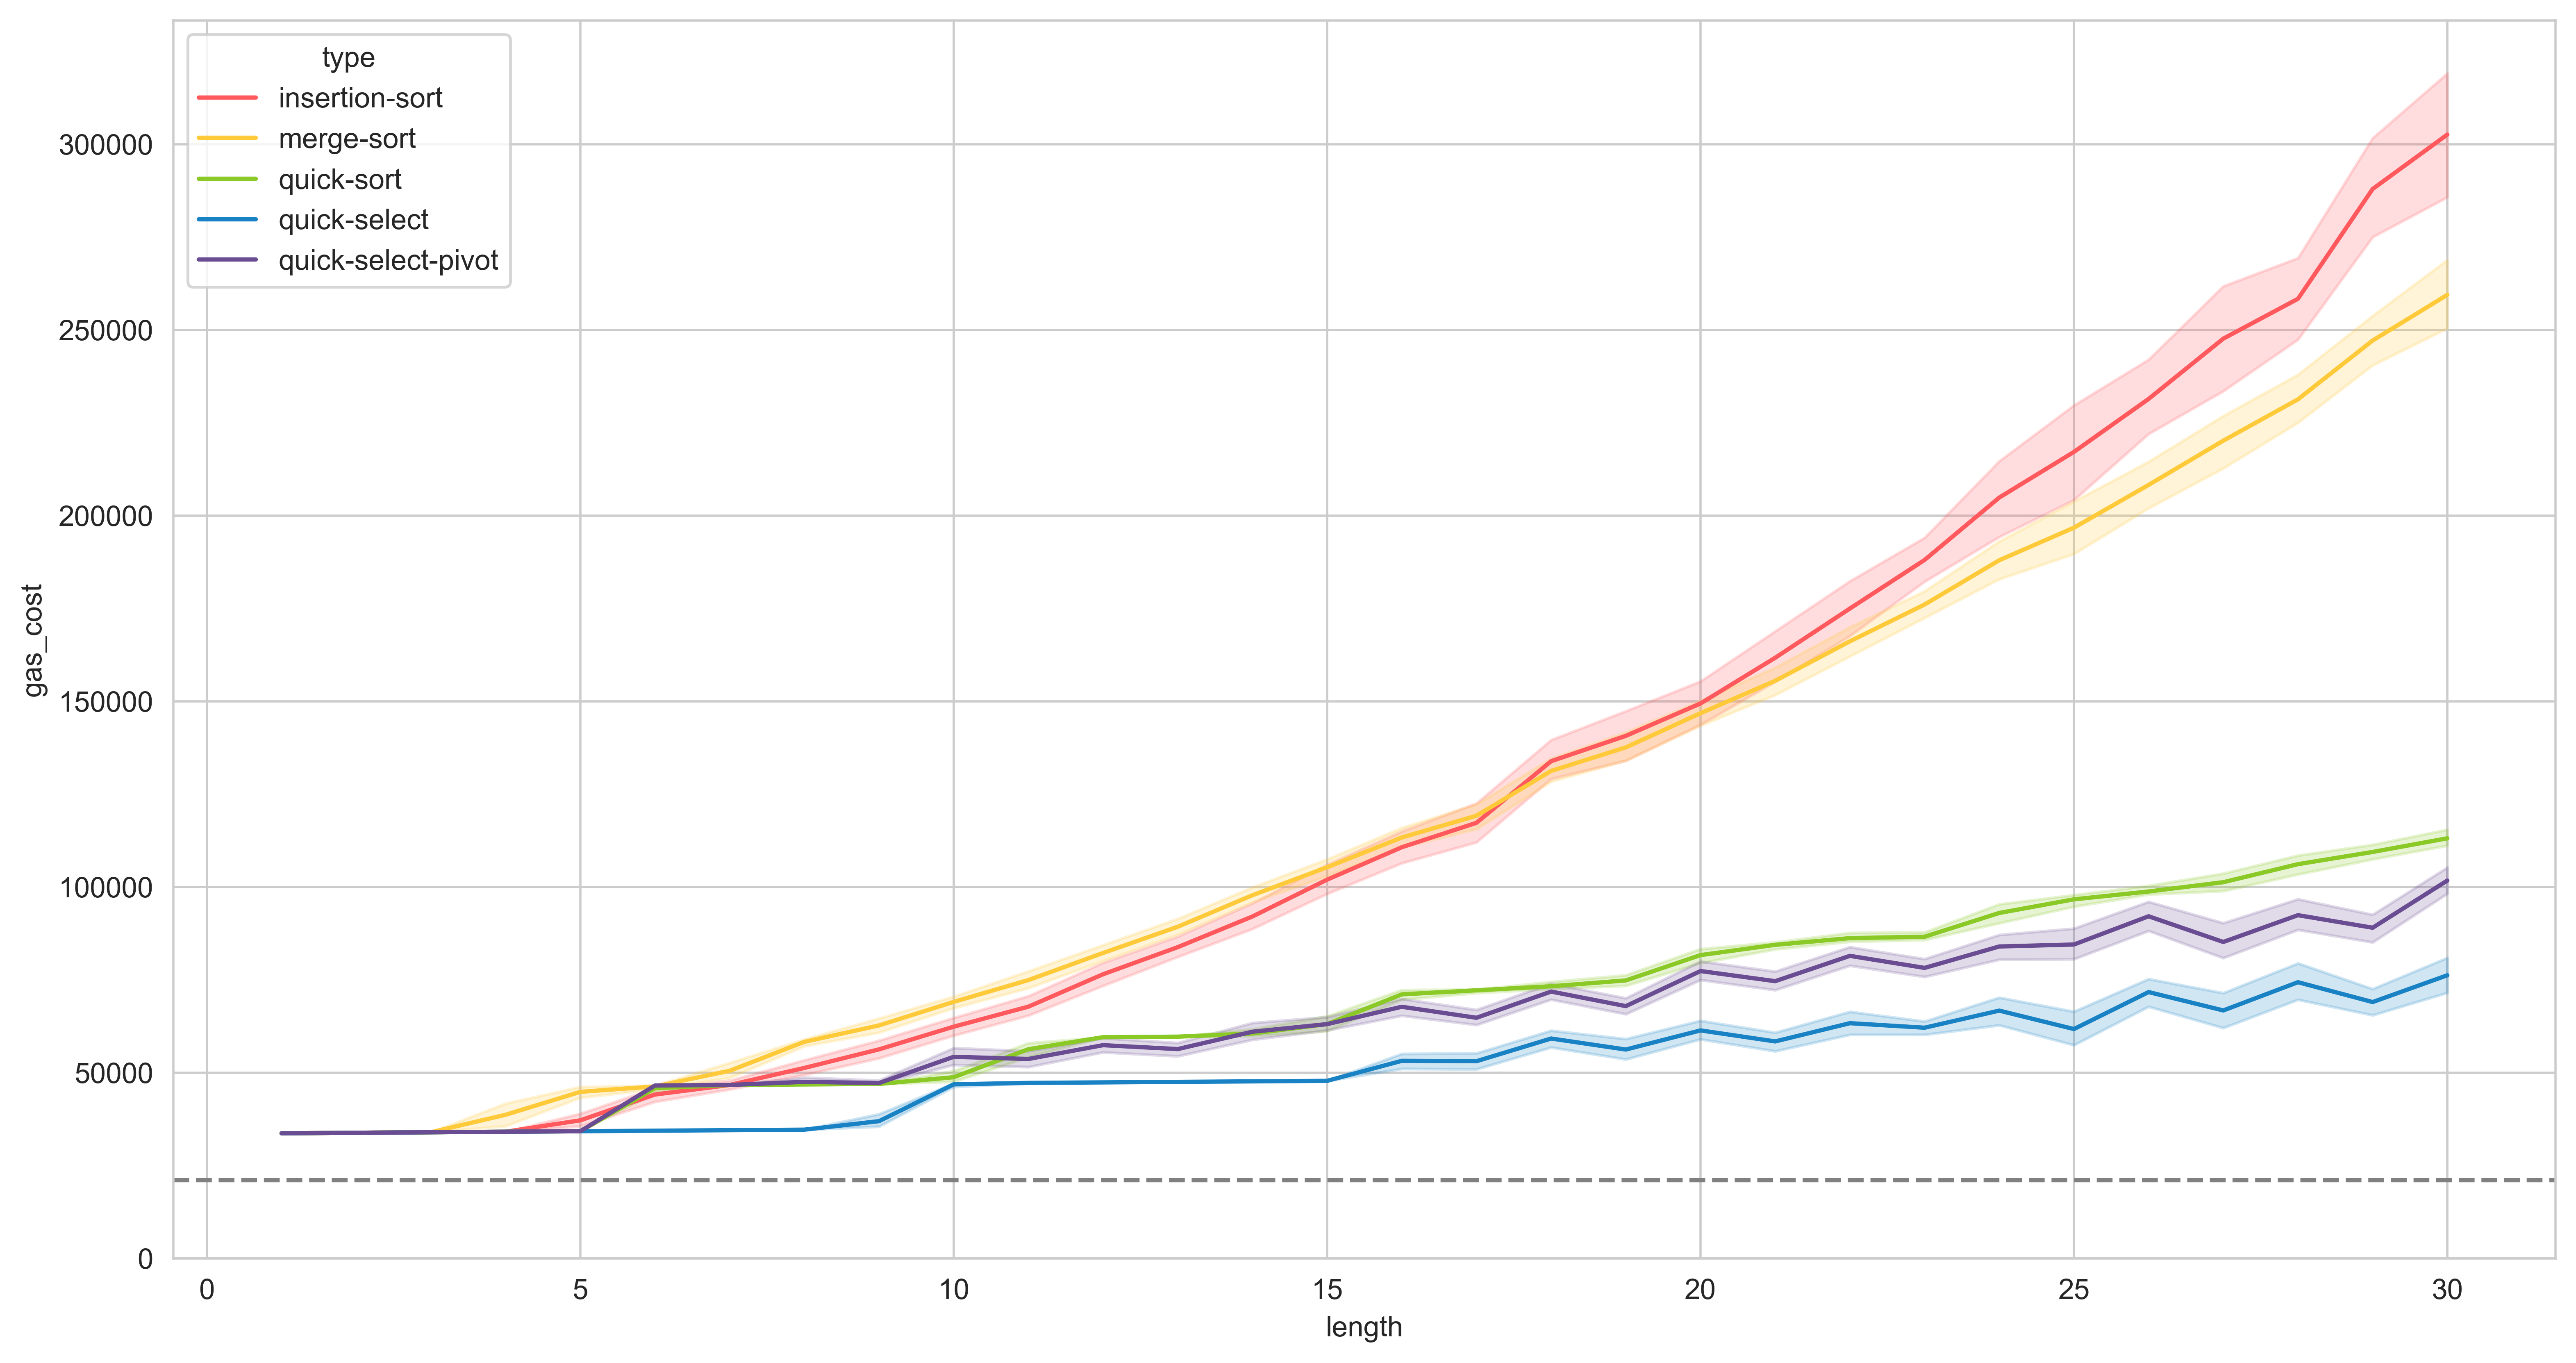

In [92]:
# first, make sure testing on same arrays
test_arrs = set()
for typ in df.type.unique():
    if not test_arrs:
        test_arrs = set(df[df.type == typ].arr.tolist())
    else:
        test_arrs &= set(df[df.type == typ].arr.tolist())

sns.set_style("whitegrid")
plt.figure(figsize=(15,8), dpi=500)

g = sns.lineplot(data=df[df.arr.isin(test_arrs)], x="length", y="gas_cost", hue="type", ci=99, palette=palette5);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey');

#plt.xlim(0, 8);
plt.ylim(0,);

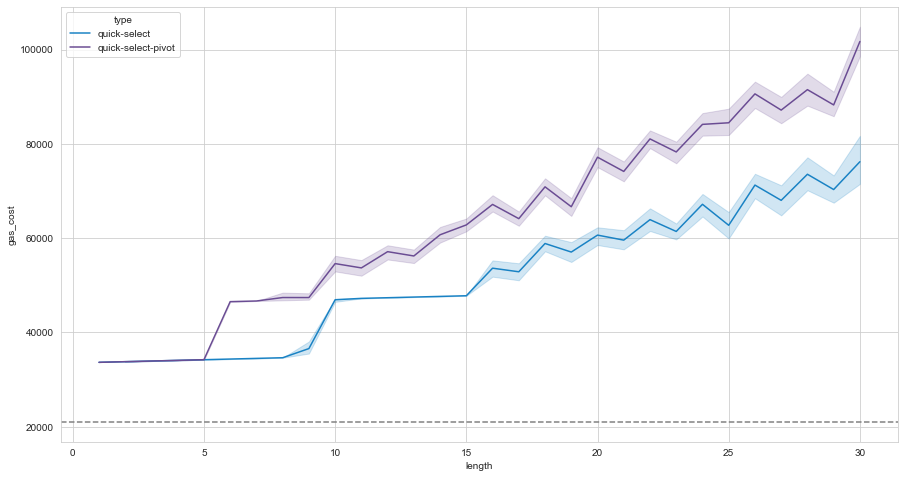

In [89]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))

g = sns.lineplot(
    data=df[df.type.isin(['quick-select-pivot', 'quick-select'])],
    x="length", y="gas_cost", hue="type",
    ci=99, palette=palette5[-2:]
);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey');

In [68]:
df

,length,gas_cost,type,arr
0,1,33661,insertion-sort,10
1,1,33661,merge-sort,10
2,1,33661,quick-sort,10
3,1,33661,quick-select,10
4,2,33800,insertion-sort,20-10
...,...,...,...,...
6300,5,34219,quick-select-pivot,10-20-50-40-30
6301,5,34219,quick-select-pivot,40-50-20-30-10
6302,5,34219,quick-select-pivot,20-30-10-50-40
6303,5,34219,quick-select-pivot,50-30-20-40-10
